In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as web
from functools import reduce
from tabulate import tabulate
from matplotlib.ticker import FormatStrFormatter
import time
import scipy.optimize as optimize
import scipy.interpolate as sci
from scipy import stats

## Main purpose of the assignment

Investment/portfolio design and analysis
- Goal of project: Build a portfolio, return and risks evaluation. Estimate a model (CAPM / Multifactors models).
- Introduction: present the companies, assets, benchmarks,…selected.
- Present your data and the selected securities in your portfolio;
- Present your methodology and the materials/sofware used (Gretl, R, Phyton, …).
- Data analysis (risks, return, correlation, …)
- Evaluation of portfolio performance and conclusion.
- Annex: Detailed information about the data collected.


In this report we are going to make an analysis of the healthcare industry, specifically focusing on the pharmaceutical sector to observe how the current global pandemic shaped the evolution of the industry

- Importing the data from yahoo finance

In [2]:
stocks = {'PFE':'PFIZER INC', 'AZN':'ASTRAZENECA', 'GSK':'GLAXOSMITHKLINE',  'SAN':'SANOFI', 'NVS':'NOVARTIS', 'JNJ':'JOHNSON & JOHNSON', 'BMY':'BRISTOL-MYERS',"ABBV": "ABBVIE INC", "UNH":"UnitedHealth Group Incorporated", "CVS":"CVS Health Corporation", "ANTM": "Anthem, Inc.", "FORTIS.NS": "Fortis Healthcare Limited", "WBA": "Walgreens Boots Alliance, Inc.", "ABT":"Abbott Laboratories", "MDT":"Medtronic plc", "MMM": "3M Company", "SYK": "Stryker Corporation", "BDX": "Becton, Dickinson and Company", "TMO": "Thermo Fisher Scientific Inc.", "BAYN.DE":"Bayer Aktiengesellschaft", "NVO": "Novo Nordisk A/S"}
funds = {'IHE' : 'ISHARES US PHARMACEUTICALS', 'XBI' :  'SPDR S&P BIOTECH', 'PJP' :  'INVESCO DYNAMIC PHARMACEUTIC', "XLV":"Health Care Select Sector SPDR Fund "}
commodoties = {'GC=F' : "Gold", "SI=F": "Silver"}
currencies = {"EURUSD%3DX": "EUR/USD Spot Rate", "USDEUR%3DX": "USD/EUR Spot Rate"}
instruments = {**stocks, **funds, **commodoties, **currencies}
tickers = list(instruments.keys())
instruments_data = {}
N = len(tickers)

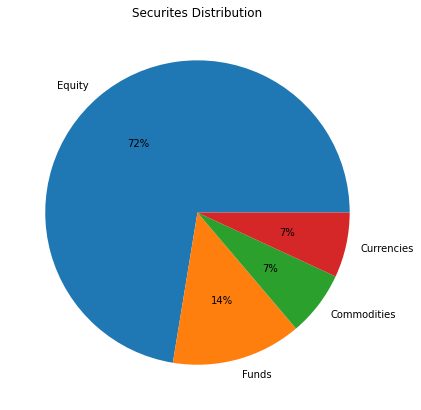

In [3]:
values = [len(stocks), len(funds), len(commodoties), len(currencies)]
labels = ["Equity", "Funds", "Commodities", "Currencies"]

plt.figure(figsize = (7,7))
plt.pie(values, labels = labels, autopct='%1.0f%%')

plt.title("Securites Distribution")
plt.show()

- We are going to consder data from the following periods

In [4]:
start = datetime.datetime(2013,1,1)
end   = datetime.datetime(2020,12,31)

- Getting instruments based on ticker

In [5]:
instruments_data = {}
for ticker, instrument in instruments.items():
    instruments_data[ticker] = web.DataReader(ticker, data_source = 'yahoo', start = start, end = end)

- Checking a specific security 

In [6]:
instruments_data["NVO"]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-01-02,33.181999,33.021999,33.127998,33.175999,690000.0,25.227345
2013-01-03,33.264000,32.902000,32.917999,33.080002,1231000.0,25.154346
2013-01-04,33.338001,33.084000,33.119999,33.276001,805500.0,25.303387
2013-01-07,33.391998,32.939999,33.063999,33.389999,1401000.0,25.390074
2013-01-08,33.756001,33.556000,33.613998,33.717999,2075000.0,25.639486
...,...,...,...,...,...,...
2020-12-24,69.879997,69.330002,69.779999,69.430000,277500.0,68.480804
2020-12-28,71.459999,69.940002,71.459999,70.250000,1256600.0,69.289597
2020-12-29,71.190002,70.389999,71.190002,70.580002,1274400.0,69.615089


- Keeping only the adjusted close price

In [7]:
for ticker, instrument in instruments.items():
  instruments_data[ticker] = instruments_data[ticker]["Adj Close"]

- Checking trading days

In [8]:
tr_days = [ len(instr) for _, instr in instruments_data.items() ] 
tr_days = pd.DataFrame(tr_days, index = tickers, columns = ["Trading Days"])
tr_days.T

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,SI=F,EURUSD%3DX,USDEUR%3DX
Trading Days,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015,...,2023,2015,2015,2015,2015,2015,2080,2083,2085,2085


In [9]:
## Merging Dataframes
data = list(instruments_data.values())
data_df = reduce(lambda x, y: pd.merge(x, y, left_index = True, right_index = True, how = 'outer'), data).dropna()
data_df.columns = tickers

In [10]:
data_df

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,SI=F,EURUSD%3DX,USDEUR%3DX
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,18.240507,16.935476,28.246660,5.295519,41.735760,56.420208,25.921173,25.103134,47.862270,41.193867,...,56.171967,25.227345,77.389977,29.520634,30.699425,35.510563,1687.900024,30.952000,1.319784,0.75770
2013-01-03,18.198267,16.903885,28.150633,5.250589,41.650757,56.340561,26.341177,24.895849,45.624485,41.276772,...,56.164188,25.154346,78.222504,29.640343,30.997049,35.554230,1673.699951,30.671000,1.318218,0.75860
2013-01-04,18.275702,16.903885,28.329863,5.321194,42.029991,56.985680,26.428347,24.581341,45.712246,41.450912,...,56.819763,25.303387,78.840202,29.931532,31.189640,35.711391,1648.099976,29.896000,1.303271,0.76730
2013-01-07,18.289787,16.889841,28.336258,5.301938,42.134617,56.866230,26.467970,24.631376,45.712246,41.484070,...,55.898815,25.390074,79.395218,30.222727,31.373468,35.824890,1645.500000,30.032000,1.306745,0.76526
2013-01-08,18.317942,16.903885,28.336258,5.308358,42.245770,56.874195,26.539291,24.095289,45.106720,41.334820,...,56.132935,25.639486,79.771172,30.481569,31.636078,35.833622,1661.500000,30.415001,1.312508,0.76190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,36.344620,47.805977,35.459026,3.040000,84.778076,151.773575,60.472191,101.611565,333.824036,66.773354,...,48.240002,69.654541,175.649033,151.088333,69.605919,110.685837,1866.599976,25.434000,1.223691,0.81720
2020-12-23,37.037083,47.845219,35.596581,3.150000,84.970360,150.998413,60.048893,102.086014,336.394897,67.558105,...,48.180000,68.668213,176.137253,151.098328,70.144875,110.765564,1874.699951,25.823999,1.218665,0.82057
2020-12-28,36.423756,48.443653,35.655533,3.140000,87.681564,152.240677,60.167023,102.254044,344.725311,67.627640,...,48.580002,69.289597,176.147217,146.419617,70.244682,111.363487,1877.199951,26.459999,1.220510,0.81933


- Ajudsted Close Evolution for each stock

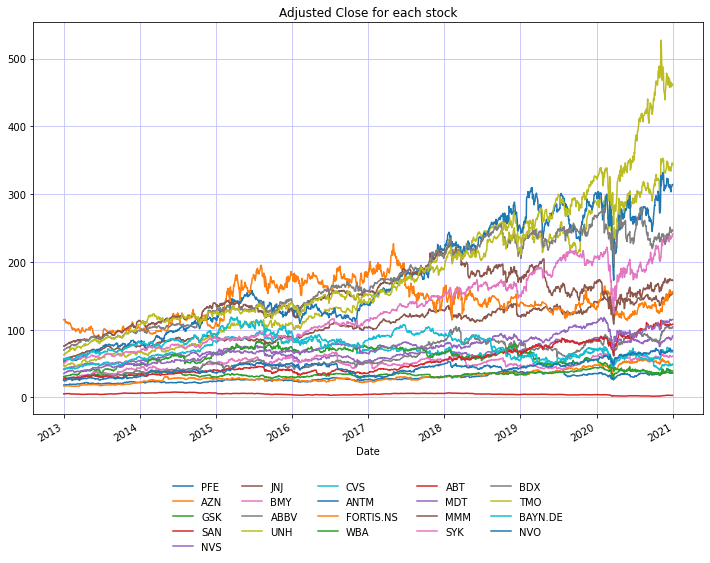

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
data_df[["PFE","AZN","GSK","SAN","NVS","JNJ","BMY","ABBV", "UNH", "CVS", "ANTM", "FORTIS.NS", "WBA", "ABT", "MDT", "MMM", "SYK", "BDX", "TMO", "BAYN.DE", "NVO"]].plot(ax = plt.gca(),grid = True)
ax.set_title('Adjusted Close for each stock')
ax.grid(c = (0.75, 0.75, 0.99))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0)

- Cummulative Returns for each stock

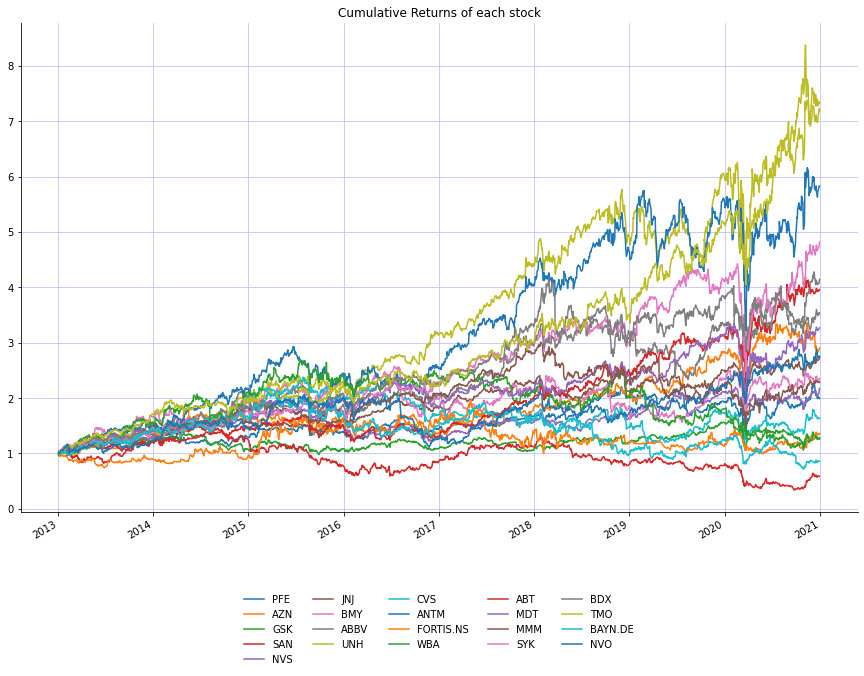

In [12]:
returns = data_df[["PFE","AZN","GSK","SAN","NVS","JNJ","BMY","ABBV", "UNH", "CVS", "ANTM", "FORTIS.NS", "WBA", "ABT", "MDT", "MMM", "SYK", "BDX", "TMO", "BAYN.DE", "NVO"]] .apply(np.log).diff(1) 
cumulative_returns = returns.cumsum().apply(np.exp)
ax = cumulative_returns.plot(title='Cumulative Returns of each stock', figsize=(15,10));
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('')
ax.grid(c = (0.75, 0.75, 0.99))
plt.show()

- Adjusted Close Evolution for each fund

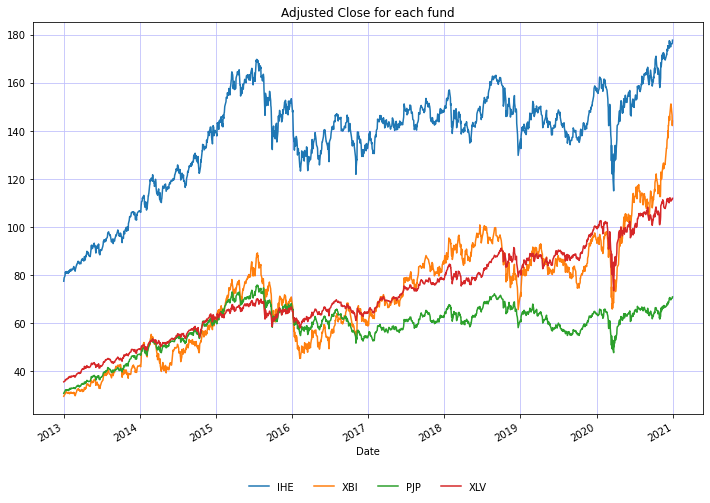

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
data_df[["IHE","XBI","PJP", "XLV"]].plot(ax = plt.gca(),grid = True)
ax.set_title('Adjusted Close for each fund')
ax.grid(c = (0.75, 0.75, 0.99))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0)

- Cummulative Returns for each fund

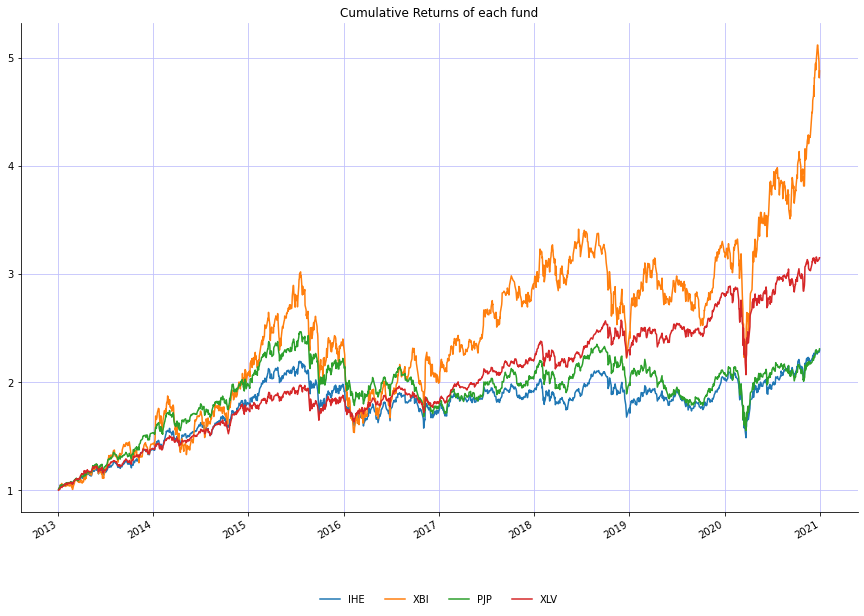

In [14]:
returns = data_df[["IHE","XBI","PJP", "XLV"]] .apply(np.log).diff(1) 
cumulative_returns = returns.cumsum().apply(np.exp)
ax = cumulative_returns.plot(title='Cumulative Returns of each fund', figsize=(15,10));
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('')
ax.grid(c = (0.75, 0.75, 0.99))
plt.show()

- Adjusted Close Evolution for each commodity

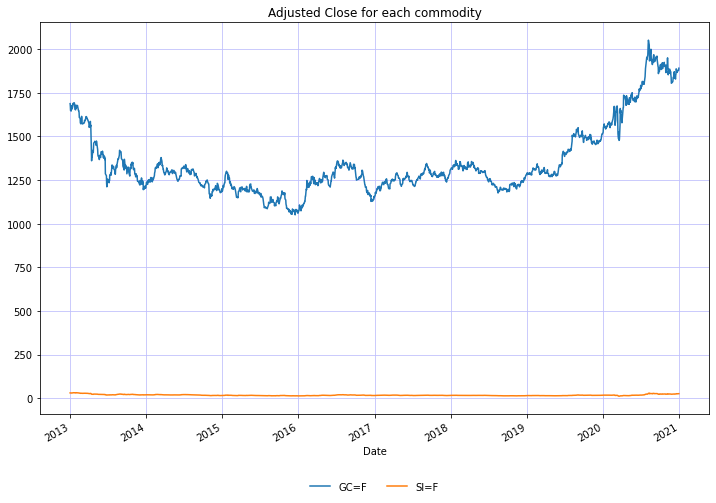

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
data_df[["GC=F", "SI=F"]].plot(ax = plt.gca(),grid = True)
ax.set_title('Adjusted Close for each commodity')
ax.grid(c = (0.75, 0.75, 0.99))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0)

- Cummulative Returns for each commodity

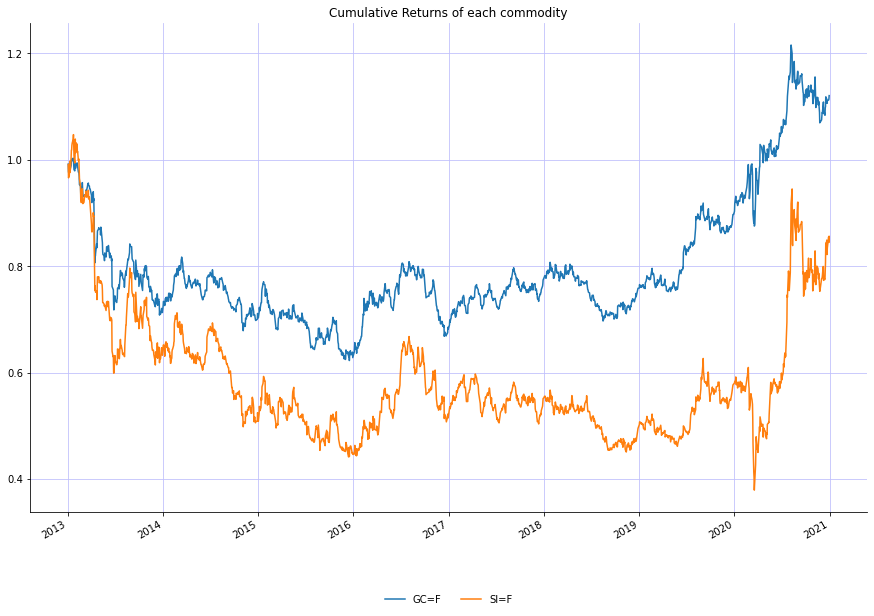

In [16]:
returns = data_df[["GC=F", "SI=F"]] .apply(np.log).diff(1) 
cumulative_returns = returns.cumsum().apply(np.exp)
ax = cumulative_returns.plot(title='Cumulative Returns of each commodity', figsize=(15,10));
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('')
ax.grid(c = (0.75, 0.75, 0.99))
plt.show()

- Adjusted Close Evolution for each currency

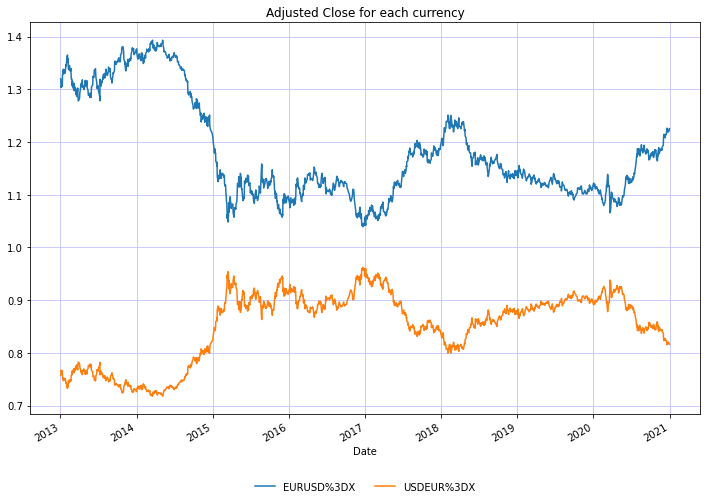

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
data_df[["EURUSD%3DX","USDEUR%3DX"]].plot(ax = plt.gca(),grid = True)
ax.set_title('Adjusted Close for each currency')
ax.grid(c = (0.75, 0.75, 0.99))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0)

- Cummulative Returns for each currency

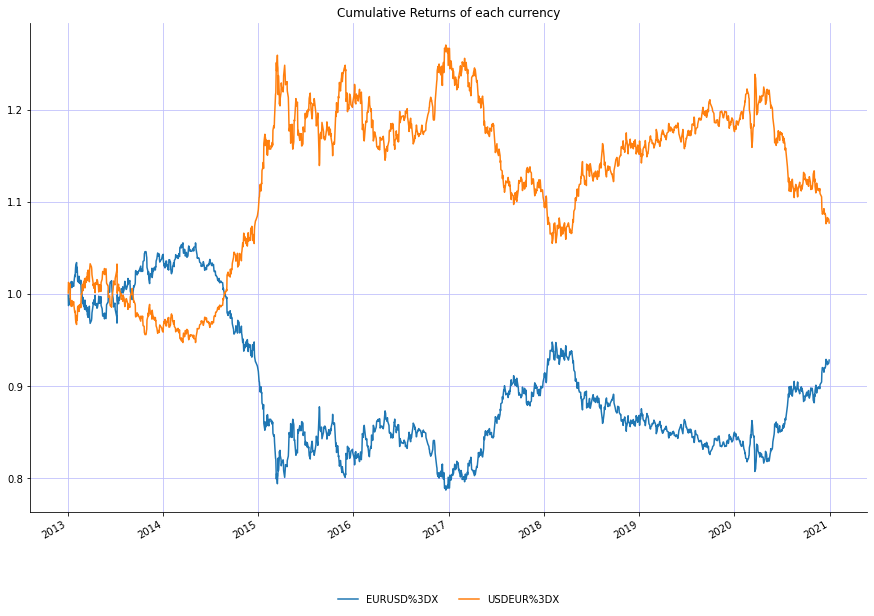

In [18]:
returns = data_df[["EURUSD%3DX","USDEUR%3DX"]] .apply(np.log).diff(1) 
cumulative_returns = returns.cumsum().apply(np.exp)
ax = cumulative_returns.plot(title='Cumulative Returns of each currency', figsize=(15,10));
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('')
ax.grid(c = (0.75, 0.75, 0.99))
plt.show()

## Calculate Descriptive Statistics

In order to calculate the returns for each of these securities we need to consider:

Simple Returns: weighted sum of the simple returns of the securities of the portfolio.

$$r_t = \frac{P_t}{P_0} - 1$$

Log Returns: The log return for a time period is the sum of the log returns of partitions of the time period.  

$$r_t = ln\left(\frac{P_t}{P_0}\right)$$

For this analysis we considered log returns since the frequency of compounding does not matter, making returns of different assets easier to compare. 

- Log Returns (daily)

In [19]:
returns_df = data_df.pct_change()
returns_df

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,SI=F,EURUSD%3DX,USDEUR%3DX
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,-0.002316,-0.001865,-0.003400,-0.008485,-0.002037,-0.001412,0.016203,-0.008257,-0.046755,0.002013,...,-0.000138,-0.002894,0.010758,0.004055,0.009695,0.001230,-0.008413,-0.009079,-0.001186,0.001188
2013-01-04,0.004255,0.000000,0.006367,0.013447,0.009105,0.011450,0.003309,-0.012633,0.001924,0.004219,...,0.011672,0.005925,0.007897,0.009824,0.006213,0.004420,-0.015295,-0.025268,-0.011338,0.011469
2013-01-07,0.000771,-0.000831,0.000226,-0.003619,0.002489,-0.002096,0.001499,0.002036,0.000000,0.000800,...,-0.016208,0.003426,0.007040,0.009729,0.005894,0.003178,-0.001578,0.004549,0.002666,-0.002659
2013-01-08,0.001539,0.000831,0.000000,0.001211,0.002638,0.000140,0.002695,-0.021764,-0.013246,-0.003598,...,0.004188,0.009823,0.004735,0.008564,0.008370,0.000244,0.009723,0.012753,0.004410,-0.004391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,-0.017121,-0.019122,-0.003589,0.009967,-0.003165,-0.001961,-0.009353,-0.008774,-0.003184,-0.021685,...,0.030439,-0.017802,0.004559,0.008542,-0.002289,-0.003052,-0.006705,-0.032118,0.001701,-0.001698
2020-12-23,0.019053,0.000821,0.003879,0.036184,0.002268,-0.005107,-0.007000,0.004669,0.007701,0.011752,...,-0.001244,-0.014160,0.002780,0.000066,0.007743,0.000720,0.004339,0.015334,-0.004107,0.004124
2020-12-28,-0.016560,0.012508,0.001656,-0.003175,0.031908,0.008227,0.001967,0.001646,0.024764,0.001029,...,0.008302,0.009049,0.000057,-0.030965,0.001423,0.005398,0.001334,0.024628,0.001513,-0.001511


- Log Returns (year)

In [20]:
returns_year = data_df.resample('Y').ffill().pct_change()
returns_year

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,SI=F,EURUSD%3DX,USDEUR%3DX
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-31,0.058464,0.238242,-0.151583,0.028319,0.199289,0.173143,0.150711,0.291104,0.397973,0.382747,...,0.132198,0.178441,0.305828,0.442246,0.291601,0.263303,-0.002410,-0.170625,-0.116126,0.131384
2015-12-31,0.078508,0.016628,0.013273,-0.379460,-0.034374,0.014197,0.197909,-0.068412,0.175122,0.026222,...,0.042180,0.396855,0.096946,0.152130,0.113205,0.067189,-0.116731,-0.149384,-0.100833,0.112140
2016-12-31,0.029263,-0.171333,0.003786,0.100399,-0.135404,0.141512,-0.143995,0.087638,0.369185,-0.186376,...,-0.121810,-0.372543,-0.126972,-0.162345,-0.201253,-0.036317,0.084803,0.153612,-0.032276,0.033352
2017-12-31,0.159018,0.332417,-0.029795,0.311432,0.194629,0.244252,0.077089,0.600749,0.398350,-0.057523,...,0.075094,0.542264,0.106402,0.437725,0.152968,0.217729,0.135913,0.070532,0.129209,-0.114425
2018-12-31,0.228458,0.132331,0.136095,-0.291477,0.052662,-0.064400,-0.146385,-0.021060,0.132000,-0.075045,...,-0.391704,-0.123375,-0.089049,-0.172373,-0.030847,0.047320,-0.020210,-0.101641,-0.042764,0.044674
2019-12-31,-0.060645,0.368442,0.296900,-0.016705,0.277649,0.173850,0.294119,0.026365,0.213529,0.169177,...,0.259589,0.290314,0.164284,0.352025,0.055323,0.219921,0.183296,0.168472,-0.021761,0.022245
2020-12-31,0.035873,0.032031,-0.173386,-0.249395,0.034206,0.103182,0.001559,0.255057,0.193356,-0.051516,...,-0.307869,0.242634,0.134263,0.523693,0.112287,0.123373,0.248597,0.479115,0.095745,-0.087379


- Plotting the log returns evolution according to each thicker (daily)

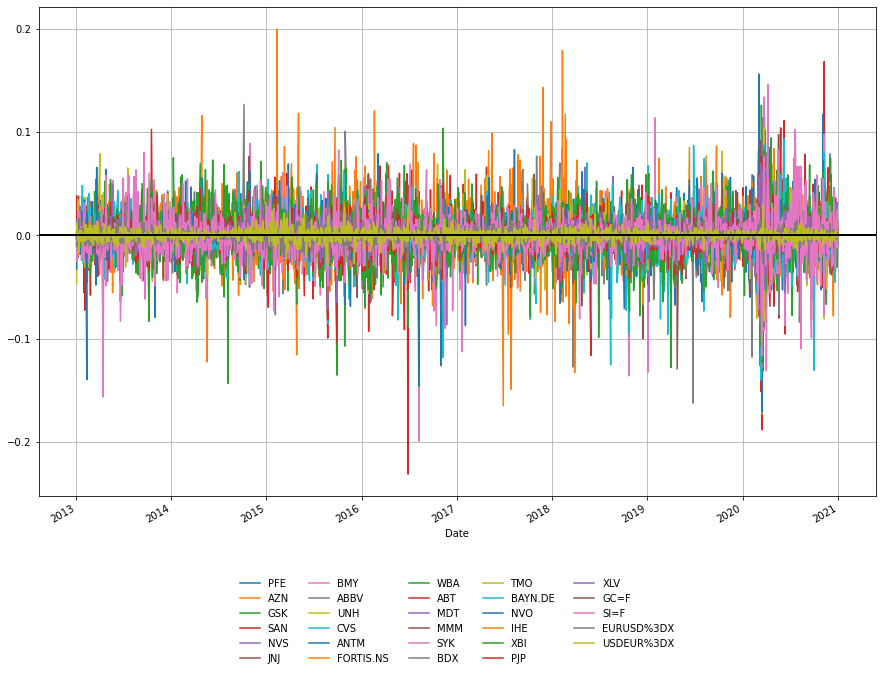

In [21]:
returns_df.plot(grid = True, figsize = (15,10)).axhline(y = 0, color = "black", lw = 2)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0)
plt.show()

- Measuring the volatility

Variance $\sigma^2$$$Var(R) = \sigma^2 = \frac{\sum_{t = 1}^{N}(R_t - \bar{R_t})^2}{N}$$
Standard Deviation $\sigma$$$\sigma =\sqrt{\sigma^2} = \sqrt{\frac{\sum_{t = 1}^{N}(R_t - \bar{R_t})^2}{N}}$$where $R_t = $ log price of instrument $i$ at the time $t$

In [22]:
STD = returns_df.groupby([returns_df.index.year]).agg('std') * np.sqrt(N) ## per year
STD_avg = STD.mean()

In [23]:
VAR = STD **0.5
VAR_avg = VAR.mean()

- Variance

In [24]:
VAR

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,SI=F,EURUSD%3DX,USDEUR%3DX
Date,,,,,,,,,,,,,,,,,,,,,
2013,0.245770,0.235394,0.229055,0.320508,0.230913,0.216704,0.284144,0.300096,0.281769,0.250148,...,0.274407,0.308260,0.222811,0.307327,0.232090,0.213587,0.295237,0.356717,0.174417,0.174027
2014,0.247393,0.312296,0.255904,0.285197,0.240503,0.234429,0.292092,0.304723,0.265205,0.233001,...,0.295427,0.286010,0.248408,0.370306,0.268203,0.233438,0.221518,0.283295,0.150499,0.150699
2015,0.278512,0.289114,0.278629,0.336687,0.269185,0.247671,0.299684,0.332560,0.312538,0.276437,...,0.338871,0.304625,0.293750,0.368564,0.306117,0.268720,0.230516,0.318786,0.209935,0.209949
2016,0.270603,0.307004,0.264802,0.416011,0.269760,0.229764,0.341070,0.324329,0.265797,0.288294,...,0.311361,0.337670,0.296236,0.382239,0.287165,0.240537,0.248831,0.326087,0.178559,0.178598
2017,0.202669,0.303154,0.222295,0.292930,0.226556,0.207371,0.289152,0.260253,0.230498,0.291097,...,0.255729,0.289023,0.218487,0.285954,0.228867,0.179592,0.197372,0.259303,0.167366,0.167076
2018,0.262672,0.266083,0.271030,0.321223,0.260297,0.281271,0.320935,0.352832,0.292673,0.327341,...,0.332534,0.300424,0.261578,0.341896,0.270698,0.250419,0.199744,0.257389,0.168649,0.168736
2019,0.271307,0.281774,0.227146,0.305781,0.241848,0.248204,0.310138,0.325844,0.300883,0.309540,...,0.339057,0.275698,0.240591,0.316020,0.250207,0.222037,0.212967,0.271410,0.140224,0.140184
2020,0.362023,0.355566,0.338629,0.471097,0.323001,0.329606,0.330914,0.355444,0.419185,0.375554,...,0.392954,0.339509,0.324381,0.387485,0.332171,0.333076,0.280744,0.409980,0.165621,0.165767


- Standard Deviation

In [25]:
STD

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,SI=F,EURUSD%3DX,USDEUR%3DX
Date,,,,,,,,,,,,,,,,,,,,,
2013,0.060403,0.055410,0.052466,0.102725,0.053321,0.046961,0.080738,0.090057,0.079394,0.062574,...,0.075299,0.095024,0.049645,0.094450,0.053866,0.045619,0.087165,0.127247,0.030421,0.030285
2014,0.061203,0.097529,0.065487,0.081338,0.057842,0.054957,0.085318,0.092856,0.070334,0.054289,...,0.087277,0.081802,0.061706,0.137127,0.071933,0.054493,0.049070,0.080256,0.022650,0.022710
2015,0.077569,0.083587,0.077634,0.113358,0.072461,0.061341,0.089811,0.110596,0.097680,0.076418,...,0.114834,0.092796,0.086289,0.135839,0.093707,0.072211,0.053138,0.101624,0.044073,0.044079
2016,0.073226,0.094251,0.070120,0.173065,0.072770,0.052792,0.116329,0.105189,0.070648,0.083113,...,0.096946,0.114021,0.087756,0.146106,0.082464,0.057858,0.061917,0.106333,0.031883,0.031897
2017,0.041075,0.091903,0.049415,0.085808,0.051327,0.043003,0.083609,0.067732,0.053129,0.084737,...,0.065398,0.083534,0.047737,0.081770,0.052380,0.032253,0.038956,0.067238,0.028011,0.027914
2018,0.068997,0.070800,0.073457,0.103184,0.067755,0.079114,0.102999,0.124491,0.085658,0.107152,...,0.110579,0.090255,0.068423,0.116893,0.073277,0.062710,0.039898,0.066249,0.028443,0.028472
2019,0.073608,0.079397,0.051595,0.093502,0.058490,0.061605,0.096185,0.106174,0.090531,0.095815,...,0.114960,0.076009,0.057884,0.099869,0.062604,0.049300,0.045355,0.073664,0.019663,0.019652
2020,0.131061,0.126427,0.114670,0.221933,0.104329,0.108640,0.109504,0.126340,0.175716,0.141041,...,0.154413,0.115266,0.105223,0.150145,0.110338,0.110940,0.078817,0.168083,0.027430,0.027479


In [26]:
pd.DataFrame(STD_avg, columns = ['Average STD']).T #### Average Volatility

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,SI=F,EURUSD%3DX,USDEUR%3DX
Average STD,0.073393,0.087413,0.069356,0.121864,0.067287,0.063552,0.095562,0.10293,0.090386,0.088142,...,0.102463,0.093588,0.070583,0.120275,0.075071,0.060673,0.056789,0.098837,0.029072,0.029061


- Covariance Matrix

In [27]:
cov_matrix = round(returns_df.cov(),6)
cov_matrix

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,SI=F,EURUSD%3DX,USDEUR%3DX
PFE,0.000207,0.000096,0.000096,0.000126,0.000095,0.000104,0.000122,0.000134,0.000125,0.000116,...,0.000081,0.000093,0.000133,0.000151,0.000136,0.000127,-0.000005,0.000011,-0.000000,-0.000000
AZN,0.000096,0.000278,0.000131,0.000105,0.000115,0.000083,0.000111,0.000114,0.000102,0.000085,...,0.000100,0.000126,0.000115,0.000151,0.000120,0.000104,0.000004,0.000020,0.000004,-0.000004
GSK,0.000096,0.000131,0.000181,0.000129,0.000104,0.000084,0.000098,0.000106,0.000105,0.000091,...,0.000099,0.000101,0.000109,0.000126,0.000112,0.000102,0.000006,0.000031,0.000004,-0.000004
SAN,0.000126,0.000105,0.000129,0.000590,0.000125,0.000099,0.000125,0.000150,0.000168,0.000150,...,0.000201,0.000112,0.000148,0.000198,0.000158,0.000144,-0.000012,0.000047,0.000015,-0.000016
NVS,0.000095,0.000115,0.000104,0.000125,0.000166,0.000078,0.000090,0.000107,0.000103,0.000085,...,0.000094,0.000108,0.000107,0.000144,0.000112,0.000101,0.000004,0.000027,0.000004,-0.000004
JNJ,0.000104,0.000083,0.000084,0.000099,0.000078,0.000153,0.000100,0.000110,0.000111,0.000095,...,0.000073,0.000076,0.000106,0.000106,0.000105,0.000111,0.000001,0.000009,0.000002,-0.000002
BMY,0.000122,0.000111,0.000098,0.000125,0.000090,0.000100,0.000320,0.000157,0.000123,0.000105,...,0.000091,0.000114,0.000153,0.000196,0.000158,0.000136,-0.000003,0.000012,0.000000,-0.000000
ABBV,0.000134,0.000114,0.000106,0.000150,0.000107,0.000110,0.000157,0.000376,0.000144,0.000128,...,0.000089,0.000116,0.000155,0.000224,0.000172,0.000156,-0.000012,0.000002,0.000001,-0.000001
UNH,0.000125,0.000102,0.000105,0.000168,0.000103,0.000111,0.000123,0.000144,0.000325,0.000157,...,0.000101,0.000104,0.000141,0.000180,0.000149,0.000158,0.000000,0.000023,-0.000001,0.000000
CVS,0.000116,0.000085,0.000091,0.000150,0.000085,0.000095,0.000105,0.000128,0.000157,0.000291,...,0.000088,0.000090,0.000117,0.000133,0.000127,0.000123,-0.000000,0.000015,-0.000001,0.000001


- Correlation Matrix

In [28]:
Correlation = returns_df.corr().style.background_gradient(cmap='Blues')
Correlation

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,ANTM,FORTIS.NS,WBA,ABT,MDT,MMM,SYK,BDX,TMO,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,SI=F,EURUSD%3DX,USDEUR%3DX
PFE,1.000000,0.399424,0.498335,0.359475,0.512684,0.580963,0.473647,0.479517,0.480673,0.471508,0.447966,0.087933,0.403819,0.535232,0.483923,0.449847,0.464862,0.470645,0.504250,0.285080,0.368859,0.681073,0.460945,0.656224,0.736247,-0.030902,0.039639,-0.000150,-0.000834
AZN,0.399424,1.000000,0.582619,0.259267,0.538044,0.402546,0.372847,0.353687,0.337963,0.299094,0.314469,0.072318,0.227821,0.417328,0.331480,0.278178,0.310254,0.312284,0.370946,0.303948,0.429568,0.507495,0.397979,0.499582,0.520116,0.022918,0.060927,0.045577,-0.046086
GSK,0.498335,0.582619,1.000000,0.394277,0.600389,0.505123,0.409136,0.406280,0.433823,0.398398,0.410254,0.116268,0.313830,0.490643,0.432212,0.384426,0.417214,0.424825,0.433542,0.372878,0.426410,0.593553,0.411330,0.576597,0.629318,0.037426,0.117141,0.049001,-0.049751
SAN,0.359475,0.259267,0.394277,1.000000,0.400809,0.330190,0.288464,0.318071,0.383719,0.363254,0.365030,0.105974,0.363460,0.373499,0.447603,0.484631,0.408560,0.309903,0.375206,0.419652,0.262676,0.448330,0.357385,0.452300,0.492191,-0.043988,0.100481,0.113877,-0.114978
NVS,0.512684,0.538044,0.600389,0.400809,1.000000,0.491969,0.391186,0.430520,0.444129,0.388098,0.407629,0.101420,0.334593,0.527605,0.476170,0.408810,0.449343,0.413733,0.486375,0.371797,0.477835,0.612506,0.489223,0.606398,0.654359,0.026679,0.107137,0.051546,-0.052570
JNJ,0.580963,0.402546,0.505123,0.330190,0.491969,1.000000,0.449540,0.458305,0.498594,0.450836,0.426145,0.092838,0.419834,0.601379,0.522814,0.510458,0.534020,0.527957,0.550991,0.299465,0.348628,0.628416,0.374479,0.587127,0.744834,0.010781,0.037852,0.025335,-0.025984
BMY,0.473647,0.372847,0.409136,0.288464,0.391186,0.449540,1.000000,0.452003,0.380562,0.345151,0.368263,0.111941,0.287304,0.452222,0.412822,0.340041,0.379847,0.371670,0.440162,0.258635,0.362456,0.627683,0.481708,0.613882,0.631440,-0.016450,0.033780,0.002119,-0.002672
ABBV,0.479517,0.353687,0.406280,0.318071,0.430520,0.458305,0.452003,1.000000,0.412685,0.386803,0.406043,0.086469,0.324368,0.483419,0.438883,0.405443,0.440784,0.409971,0.454759,0.232721,0.339936,0.587104,0.505893,0.616619,0.666596,-0.055141,0.006616,0.010998,-0.011806
UNH,0.480673,0.337963,0.433823,0.383719,0.444129,0.498594,0.380562,0.412685,1.000000,0.510840,0.786724,0.117828,0.372007,0.536504,0.531312,0.461293,0.514672,0.457563,0.494352,0.283796,0.326886,0.575197,0.436676,0.574361,0.726624,0.000371,0.064298,-0.005085,0.004122
CVS,0.471508,0.299094,0.398398,0.363254,0.388098,0.450836,0.345151,0.386803,0.510840,1.000000,0.461771,0.016742,0.593694,0.443408,0.427668,0.416673,0.406293,0.426388,0.405439,0.263849,0.301004,0.505956,0.341785,0.516987,0.597849,-0.000002,0.045274,-0.010253,0.010007


#### Portfolio Optimization: Monte Carlo

So we now have a way to evaluate how well our portfolio is allocated. It involves, calculating the expected returns, the expected volatility, and then from here we use the Sharpe Ratio to quantify how well our portfolio is allocated based on a risk perspective. The big question here is, "If we know that we want to get a higher sharpe ratio, what is the portfolio allocation we need to achieve this?"

- First, we could test a bunch of different random allocations and see which ones produces the highest Sharpe Ratio. 
- Second, we could use mathematical optimization defined by some constrains to arrive at the optimial allocation. 

In the next section, we will run the "try a bunch of random allocations" method. Now, there is a more formal name for this process, a Monte Carlo Simulation.

Monte Carlo simulations are used to model the probability of different outcomes in a process that cannot easily be predicted due to the intervention of random variables. It is a technique used to understand the impact of risk and uncertainty in prediction and forecasting models.

- Which securities are we going to choose?

In [29]:
selected_securities = data_df[["PFE","AZN","JNJ", "GSK", "IHE", "XBI",'PJP', "GC=F"]].pct_change()

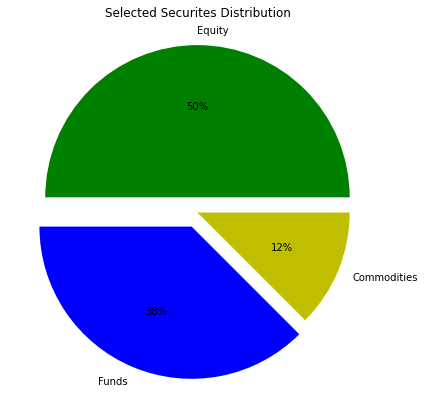

In [30]:
stocks = {'PFE':'PFIZER INC', 'AZN':'ASTRAZENECA', 'GSK':'GLAXOSMITHKLINE', 'JNJ':'JOHNSON & JOHNSON'} 
funds = {"IHE": 'ISHARES US PHARMACEUTICALS','XBI' :  'SPDR S&P BIOTECH', 'PJP' :  'INVESCO DYNAMIC PHARMACEUTIC'}
commodoties = {'GC=F' : "Gold"}

values = [len(stocks), len(funds), len(commodoties)]
labels = ["Equity", "Funds", "Commodities"]

plt.figure(figsize = (7,7))
plt.pie(values, labels = labels, autopct='%1.0f%%', explode = [0.1,0.1,0], colors = "gby")

plt.title("Selected Securites Distribution")
plt.show()

- Creating 50000 random portfolios

In [31]:
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []
list_tickers = ["PFE","AZN", "JNJ", "GSK", "IHE", "XBI",'PJP', "GC=F",]
num_assets = len(list_tickers)
num_portfolios = 50000
annual_rtns = selected_securities.mean() * 252


cov_daily = selected_securities.cov()
cov_annual = cov_daily * 252

for single_portfolio in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets),size=1)
    weights = weights[0]
    returns = np.dot(weights, annual_rtns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = (returns-0.01) / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio

portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

for counter, symbol in enumerate(list_tickers):
    portfolio[symbol +' weight'] = [weight[counter] for weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)
    
# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' weight' for stock in list_tickers]
# reorder dataframe columns
df = df[column_order]

In [32]:
df

,Returns,Volatility,Sharpe Ratio,PFE weight,AZN weight,JNJ weight,GSK weight,IHE weight,XBI weight,PJP weight,GC=F weight
0,0.199977,0.202886,0.936374,0.039714,0.088262,0.234002,0.026799,0.004654,0.346486,0.152123,0.107960
1,0.178032,0.200784,0.836881,0.098782,0.289866,0.010157,0.069341,0.325283,0.159575,0.012031,0.034964
2,0.186985,0.206478,0.857162,0.126430,0.092273,0.002059,0.028291,0.108462,0.362075,0.102817,0.177592
3,0.164096,0.197248,0.781232,0.070897,0.312416,0.017409,0.233763,0.010168,0.144628,0.181456,0.029263
4,0.149216,0.193964,0.717745,0.285066,0.043169,0.006877,0.183108,0.042593,0.136201,0.264171,0.038815
...,...,...,...,...,...,...,...,...,...,...,...
49995,0.108965,0.183237,0.540094,0.136302,0.120935,0.000079,0.522184,0.109978,0.032287,0.045961,0.032274
49996,0.138809,0.177904,0.724036,0.142577,0.070133,0.164685,0.267508,0.176482,0.061565,0.093494,0.023556
49997,0.172995,0.188076,0.866645,0.236417,0.260608,0.021953,0.112682,0.015465,0.226292,0.023858,0.102725
49998,0.165097,0.197550,0.785102,0.041441,0.031591,0.205933,0.324697,0.079345,0.239421,0.073601,0.003970


Now producing a bunch of different weights is one thing, but it helps to see the results of our simulation using a graph. We will use matplotlib to create a scatter plot that shows the relationship between the overall volatility of our portfolio, and the expected returns from it. Ideally, what we should see is that as we take on more risk, we should be getting higher risk-adjusted returns. The opposite can be said for volaility, the less volatility we take on the lower the expected return we should be getting.

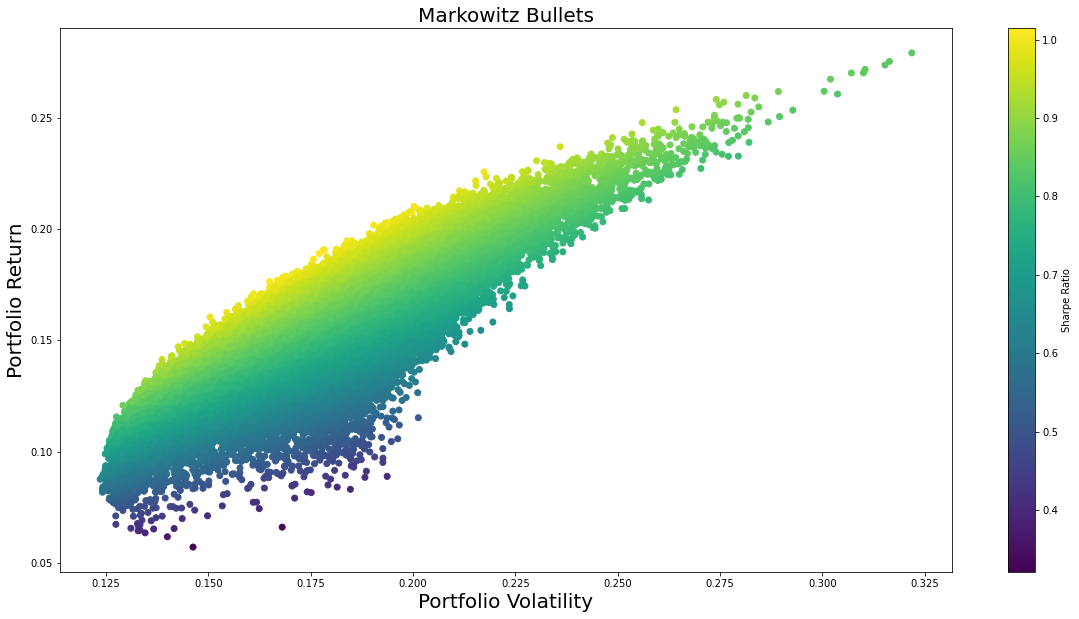

In [33]:
max_sharpe_row_ = df.iloc[df['Sharpe Ratio'].idxmax()]
max_sharpe_RTN = max_sharpe_row_['Returns']
max_sharpe_VOL = max_sharpe_row_['Volatility']
min_vol_row_ = df.iloc[df['Volatility'].idxmin()]
min_vol_RTN = min_vol_row_['Returns']
min_vol_VOL = min_vol_row_['Volatility']
plt.figure(figsize=(20,10))
plt.scatter(port_volatility, port_returns, c=sharpe_ratio,
                  cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Portfolio Volatility', fontsize = 20)
plt.ylabel('Portfolio Return', fontsize = 20)
plt.title('Markowitz Bullets', fontsize = 20)
plt.show()

- Statistics for portfolios

In [34]:
df.describe()

,Returns,Volatility,Sharpe Ratio,PFE weight,AZN weight,JNJ weight,GSK weight,IHE weight,XBI weight,PJP weight,GC=F weight
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.151624,0.178252,0.791650,0.125717,0.124968,0.125418,0.124852,0.124705,0.124601,0.124572,0.125167
std,0.026283,0.022913,0.083287,0.110542,0.110411,0.110336,0.109671,0.110227,0.109881,0.110093,0.110537
min,0.056987,0.123553,0.321277,0.000004,0.000003,0.000002,0.000007,0.000003,0.000001,0.000005,0.000003
25%,0.134370,0.163413,0.741517,0.040464,0.040225,0.040949,0.039720,0.039696,0.040140,0.039862,0.040021
50%,0.150709,0.178178,0.799090,0.095067,0.094420,0.094631,0.095409,0.094249,0.093746,0.093781,0.094497
75%,0.167800,0.191666,0.850252,0.181301,0.179372,0.181278,0.180094,0.179555,0.179242,0.178653,0.179781
max,0.279370,0.321870,1.014635,0.790415,0.830377,0.761442,0.741133,0.812044,0.856457,0.832794,0.802811


- Portfolio with highest Sharpe Ratio

In [35]:
max_sharpe_ratio = df.loc[df['Sharpe Ratio'].idxmax()]
print("Portfolio with highest sharpe ratio")
print("-----------------------------------")
max_sharpe_ratio

Portfolio with highest sharpe ratio
-----------------------------------


Returns         0.190642
Volatility      0.178036
Sharpe Ratio    1.014635
PFE weight      0.031976
AZN weight      0.136001
JNJ weight      0.390514
GSK weight      0.026383
IHE weight      0.013443
XBI weight      0.268139
PJP weight      0.003812
GC=F weight     0.129733
Name: 40760, dtype: float64

- Portfolio with lowest Volatility

In [36]:
min_volatility = df.loc[df['Volatility'].idxmin()]
print("Portfolio with lowest volatility")
print("-----------------------------------")
min_volatility

Portfolio with lowest volatility
-----------------------------------


Returns         0.087510
Volatility      0.123553
Sharpe Ratio    0.627340
PFE weight      0.087650
AZN weight      0.031909
JNJ weight      0.207617
GSK weight      0.100421
IHE weight      0.039764
XBI weight      0.005756
PJP weight      0.017668
GC=F weight     0.509215
Name: 1662, dtype: float64

### Optimization: A second approach

Alright, now remember that up above I mentioned that we would be exploring multiple ways to optimize our portfolio. The first was using Monte Carlo Simulation that would try thousands of random values and find the best values. The draw back to using the Monte Carlo Simulation is that it's not the most efficent way to find the optimial values. Instead we can use mathematical techniques to easily arrive at the optimial values.

In [37]:
def portfolio_stats(weights):
    
    '''
    We can gather the portfolio performance metrics for a specific set of weights.
    This function will be important because we'll want to pass it to an optmization
    function to get the portfolio with the best desired characteristics.
    
    Note: Sharpe ratio here uses a risk-free short rate of 0.
    
    Paramaters: 
    -----------
        weights: array, 
            asset weights in the portfolio.
        returns: dataframe
            a dataframe of returns for each asset in the trial portfolio    
    
    Returns: 
    --------
        dict of portfolio statistics - mean return, volatility, sharp ratio.
    '''

    # Convert to array in case list was passed instead.
    weights = np.array(weights)
    port_return = np.sum(selected_securities.mean() * weights) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(selected_securities.cov() * 252, weights)))
    sharpe = (port_return - 0.01) / port_vol

    return {'return': port_return, 'volatility': port_vol, 'sharpe': sharpe}

The Optimization Function

- constraints: In this case, our key constraint is that all the portfolio weights should sum to 1.0. What this means, practically, is that all of our cash should be invested in an asset or ETF.

- bounds: Bounds is going to refer to how much of our portfolio one asset can take up, from 0.0 to 1.0. 0.0 being a 0% position, and 1.0 being a 100% position (That stock or ETF is our only holding). N

- initializer: Initializer just sets the initial weights of the optimization algorithm so that it has a starting point. Here we’ll just set them so that each stock takes up an equal percentage of the portfolio.

In [38]:
# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.

constraints = ({'type' : 'eq', 'fun': lambda x: np.sum(x) -1})

# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.

bounds = tuple((0,1) for x in range(num_assets))

# We need to create an initial guess to start with, and usually the best initial guess is just an even distribution. 

initializer = num_assets * [1./num_assets,]

All optimization and minimization functions require some kind of metric to optimize on - usually this means minimizing something. This often involves tradeoffs because even though multi-variables can be considered, typically you can only minimize on score metric. In this example, we’re going to try optimizing on three seperate metrics just to get the hang of this. The metrics will be:

- Sharpe Ratio: Risk adjusted returns. This will create the portfolio with the highest return per unit of incurred risk.
- Variance (risk): Purely risk. This will create the portfolio with the lowest risk

To do this, let’s define functions that will generate all of these metrics for us and package them into a dictionary that we can pass to our soon-to-be created minimization functions.

- Sharpe Ratio function

In [39]:
def minimize_sharpe(weights):  
    return -portfolio_stats(weights)['sharpe'] 

- Optimal Volatility function

In [40]:
def minimize_volatility(weights, ):  
    # Note that we don't return the negative of volatility here because we 
    # want the absolute value of volatility to shrink, unlike sharpe.
    return portfolio_stats(weights)['volatility'] 

In [41]:
def minimize_return(weights, ): 
    return -portfolio_stats(weights)["return"]

In [42]:
optimal_sharpe=optimize.minimize(minimize_sharpe,initializer,method = 'SLSQP',bounds = bounds,constraints = constraints)

print(optimal_sharpe)

     fun: -1.0427729578116975
     jac: array([ 0.10063772, -0.05696678, -0.0564694 ,  0.43718278,  0.23759621,
       -0.05616231,  0.24980393, -0.05621383])
 message: 'Optimization terminated successfully'
    nfev: 63
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.00000000e+00, 1.89651983e-01, 4.52725265e-01, 2.33991364e-17,
       0.00000000e+00, 2.40301106e-01, 0.00000000e+00, 1.17321646e-01])


In [43]:
optimal_sharpe_weights=optimal_sharpe['x'].round(4)
list(zip(list_tickers,list(optimal_sharpe_weights)))

[('PFE', 0.0),
 ('AZN', 0.1897),
 ('JNJ', 0.4527),
 ('GSK', 0.0),
 ('IHE', 0.0),
 ('XBI', 0.2403),
 ('PJP', 0.0),
 ('GC=F', 0.1173)]

- Optimal Portfolio after optimizing sharpe ratio

In [44]:
optimal_stats = portfolio_stats(optimal_sharpe_weights)

print('Optimal Portfolio Return: ', round(optimal_stats['return']*100,4))
print('Optimal Portfolio Volatility: ', round(optimal_stats['volatility']*100,4))
print('Optimal Portfolio Sharpe Ratio: ', round(optimal_stats['sharpe'],4))

Optimal Portfolio Return:  19.4697
Optimal Portfolio Volatility:  17.7121
Optimal Portfolio Sharpe Ratio:  1.0428


- Efficinet Frontier

The efficient frontier is defined as all the portfolios that maximize the return for a given level of volatility. There can only be one of these for each level of volatility, and when plotted forms a curve around the cluster of portfolio values.

What we do is we iterate through a series of target returns, and for each target return we find the portfolio with the minimal level of volatility. To do this, we’ll need to minimize volatility instead of the negative of the sharpe ratio. This process is exactly the same as the process for sharpe ratio, except we substitute in our minimizing function for volatility instead.

- Minimize volatility

In [45]:
optimal_variance=optimize.minimize(minimize_volatility,initializer,method = 'SLSQP',bounds = bounds,constraints = constraints)

print(optimal_variance)
optimal_variance_weights=optimal_variance['x'].round(4)

list(zip(list_tickers,list(optimal_variance_weights)))

     fun: 0.12334980746061813
     jac: array([0.12354403, 0.1226922 , 0.12321399, 0.12321043, 0.12342539,
       0.14484172, 0.12326535, 0.12344872])
 message: 'Optimization terminated successfully'
    nfev: 82
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([9.20500887e-02, 3.93670324e-02, 2.01706301e-01, 1.07811894e-01,
       4.12729761e-02, 5.85469173e-18, 2.33526200e-02, 4.94439087e-01])


[('PFE', 0.0921),
 ('AZN', 0.0394),
 ('JNJ', 0.2017),
 ('GSK', 0.1078),
 ('IHE', 0.0413),
 ('XBI', 0.0),
 ('PJP', 0.0234),
 ('GC=F', 0.4944)]

In [46]:
# Make an array of 50 returns betweeb the minimum return and maximum return
# discovered earlier.
target_returns = np.linspace(min(port_returns),max(port_returns),50)

# Initialize optimization parameters
minimal_volatilities = []
bounds = tuple((0,1) for x in weights)
initializer = num_assets * [1./num_assets,]

for target_return in target_returns:
    
    constraints = ({'type':'eq','fun': lambda x: portfolio_stats(x)['return']-target_return},
                   {'type':'eq','fun': lambda x: np.sum(x)-1})
       
    optimal = optimize.minimize(minimize_volatility,
                              initializer,
                              method = 'SLSQP',
                              bounds = bounds,
                              constraints = constraints)
    
    minimal_volatilities.append(optimal['fun'])

minimal_volatilities = np.array(minimal_volatilities)

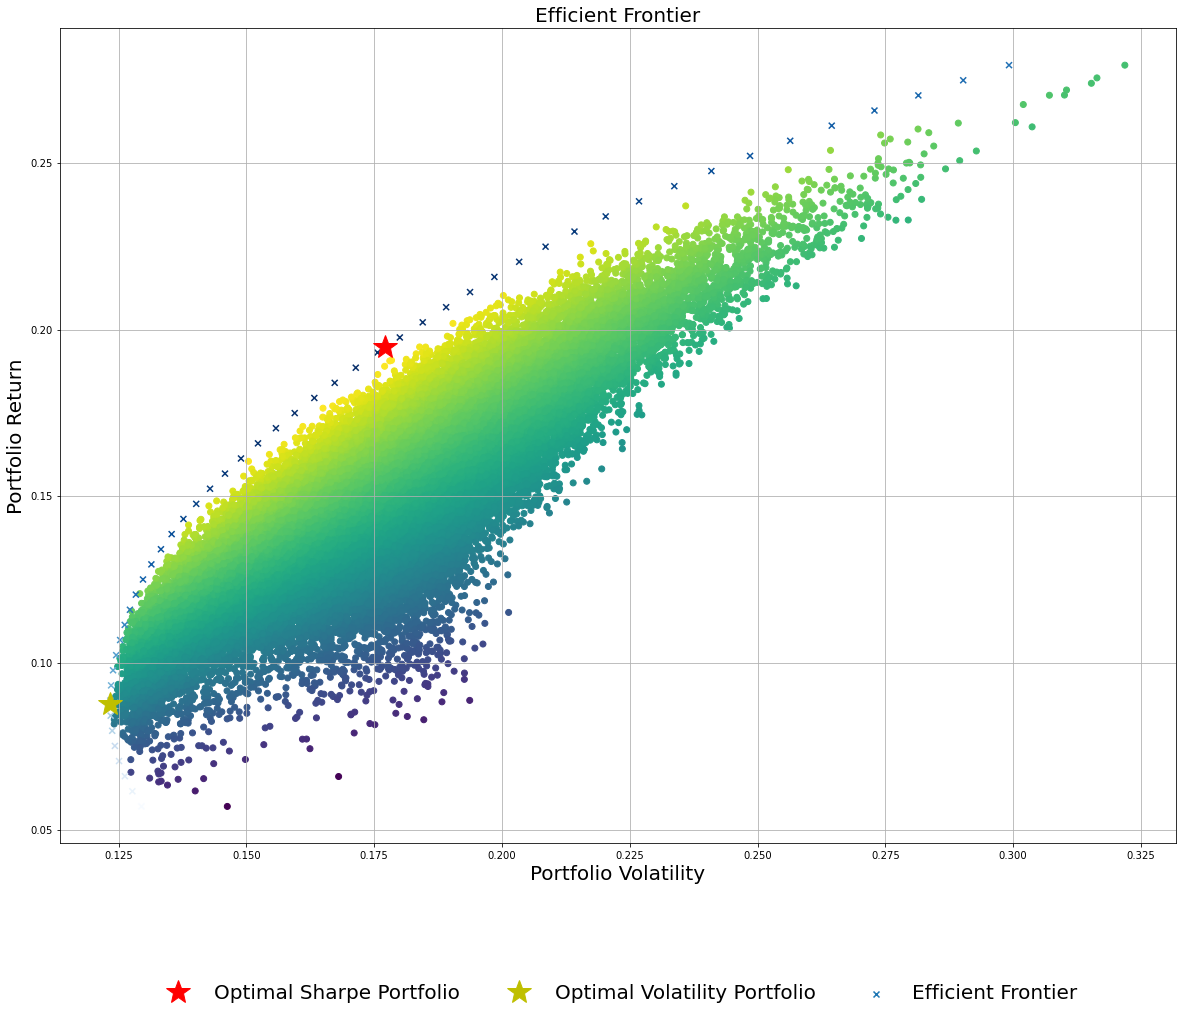

In [47]:
# initialize figure size

plt.figure(figsize=(20,15))

plt.scatter(port_volatility,
            port_returns,
            c = (np.array(port_returns) / np.array(port_volatility)),
            marker = 'o')

plt.scatter(minimal_volatilities,
            target_returns,
            c = (target_returns / minimal_volatilities),
        marker = 'x', cmap = "Blues", label = "Efficient Frontier")

plt.plot(portfolio_stats(optimal_sharpe_weights)['volatility'], ###Optimal Sharp
         portfolio_stats(optimal_sharpe_weights)['return'],
         'r*',
         markersize = 25.0, label = "Optimal Sharpe Portfolio")

plt.plot(portfolio_stats(optimal_variance_weights)['volatility'], ### Optimal variance
         portfolio_stats(optimal_variance_weights)['return'],
         'y*',
         markersize = 25.0, label = "Optimal Volatility Portfolio")

plt.title("Efficient Frontier", fontsize = 20)
plt.xlabel('Portfolio Volatility', fontsize = 20)
plt.ylabel('Portfolio Return', fontsize = 20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize = 20).get_frame().set_linewidth(0.0)
plt.grid()
plt.show()

- Defining the Capital Alocation Line

In [48]:
min_index = np.argmin(minimal_volatilities)
ex_returns = target_returns[min_index:]
ex_volatilities = minimal_volatilities[min_index:]

var = sci.splrep(ex_returns, ex_volatilities)

def func(x):
    # Spline approximation of the efficient frontier
    spline_approx = sci.splev(x,var,der=0)  
    return spline_approx

def d_func(x):
    # first derivative of the approximate efficient frontier function
    deriv = sci.splev(x,var,der=1)
    return deriv

def eqs(p, rfr = 0.01):

    #rfr = risk free rate
    
    eq1 = rfr - p[0]
    eq2 = rfr + p[1] * p[2] - func(p[2])
    eq3=p[1] - d_func(p[2]) 
    return eq1, eq2, eq3

# Initializing the weights can be tricky - I find taking the half-way point between your max return and max
# variance typically yields good results.

rfr = 0.01
m=  np.array(port_volatility).max() / 2
l = np.array(port_returns).max() / 2

optimal = optimize.fsolve(eqs, [rfr,m,l])

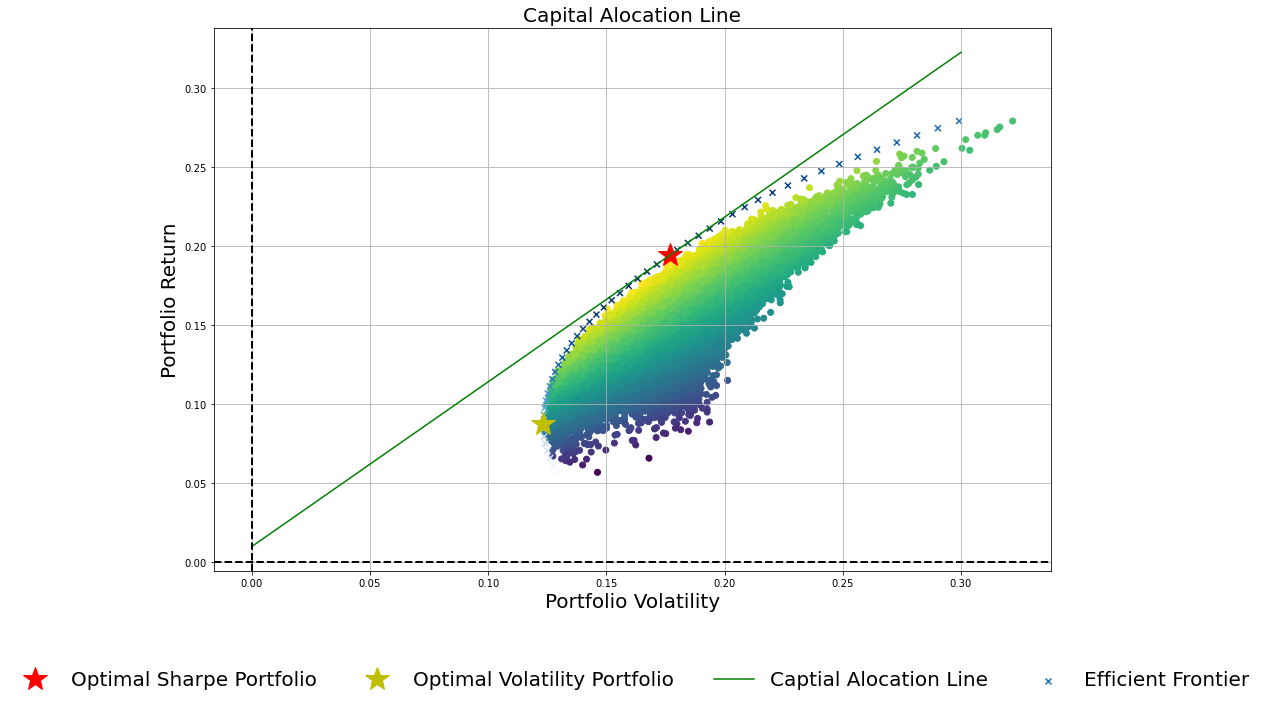

In [49]:
# initialize figure size

plt.figure(figsize=(15,10))

plt.scatter(port_volatility,
            port_returns,
            c = (np.array(port_returns) / np.array(port_volatility)),
            marker = 'o')

plt.scatter(minimal_volatilities,
            target_returns,
            c = (target_returns / minimal_volatilities),
        marker = 'x', cmap = "Blues", label = "Efficient Frontier")

plt.plot(portfolio_stats(optimal_sharpe_weights)['volatility'], ###Optimal Sharp
         portfolio_stats(optimal_sharpe_weights)['return'],
         'r*',
         markersize = 25.0, label = "Optimal Sharpe Portfolio")

plt.plot(portfolio_stats(optimal_variance_weights)['volatility'], ### Optimal variance
         portfolio_stats(optimal_variance_weights)['return'],
         'y*',
         markersize = 25.0, label = "Optimal Volatility Portfolio")


cal_x  = np.linspace(0.0, 0.3, 50)
cal_y = rfr + cal_x * optimal_stats['sharpe']
plt.plot(cal_x, cal_y, color = "g", label = "Captial Alocation Line")

plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)

plt.title("Capital Alocation Line", fontsize = 20)
plt.xlabel('Portfolio Volatility', fontsize = 20)
plt.ylabel('Portfolio Return', fontsize = 20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize = 20).get_frame().set_linewidth(0.0)
plt.show()

- Portfolio comparision

In [50]:
data_set = pd.DataFrame({"Max Sharpe Ratio Portfolio": max_sharpe_ratio,
                        "Optimal Sharpe Ratio Portfolio":[round(optimal_stats['return'],6), round(optimal_stats['volatility'],6), 
                                                round(optimal_stats['sharpe'],6), list(optimal_sharpe_weights)[0],
                                               list(optimal_sharpe_weights)[1],list(optimal_sharpe_weights)[2],list(optimal_sharpe_weights)[3]
                                               ,list(optimal_sharpe_weights)[4],list(optimal_sharpe_weights)[5],list(optimal_sharpe_weights)[6],
                                               list(optimal_sharpe_weights)[7]],})


data_set

,Max Sharpe Ratio Portfolio,Optimal Sharpe Ratio Portfolio
Returns,0.190642,0.194697
Volatility,0.178036,0.177121
Sharpe Ratio,1.014635,1.042773
PFE weight,0.031976,0.000000
AZN weight,0.136001,0.189700
JNJ weight,0.390514,0.452700
GSK weight,0.026383,0.000000
IHE weight,0.013443,0.000000
XBI weight,0.268139,0.240300
PJP weight,0.003812,0.000000


- Data for our Benchmark

In [51]:
benchmark_price = web.get_data_yahoo('^GSPC',
                               start = "2013-01-01",
                               end = '2020-12-31')
                               
benchmark_ret = benchmark_price["Adj Close"].pct_change()[1:]

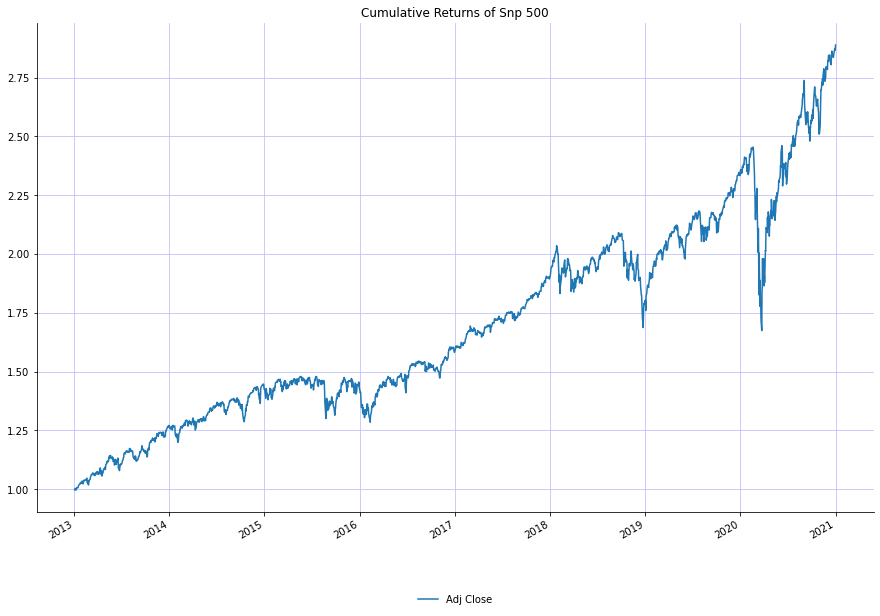

In [52]:
returns = benchmark_ret.apply(np.log).diff(1) 
cumulative_returns = benchmark_ret.cumsum().apply(np.exp)
ax = cumulative_returns.plot(title='Cumulative Returns of Snp 500', figsize=(15,10));
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('')
ax.grid(c = (0.75, 0.75, 0.99))
plt.show()

In [53]:
tickers = ["PFE","AZN","JNJ", "GSK", "IHE", "XBI",'PJP', "GC=F"]

price_data = web.get_data_yahoo(tickers,
                               start = '2013-01-01',
                               end = '2020-12-31')
price_data = price_data['Adj Close'].pct_change()[1:]

In [54]:
port_ret = (price_data * list(optimal_sharpe_weights)).sum(axis = 1)

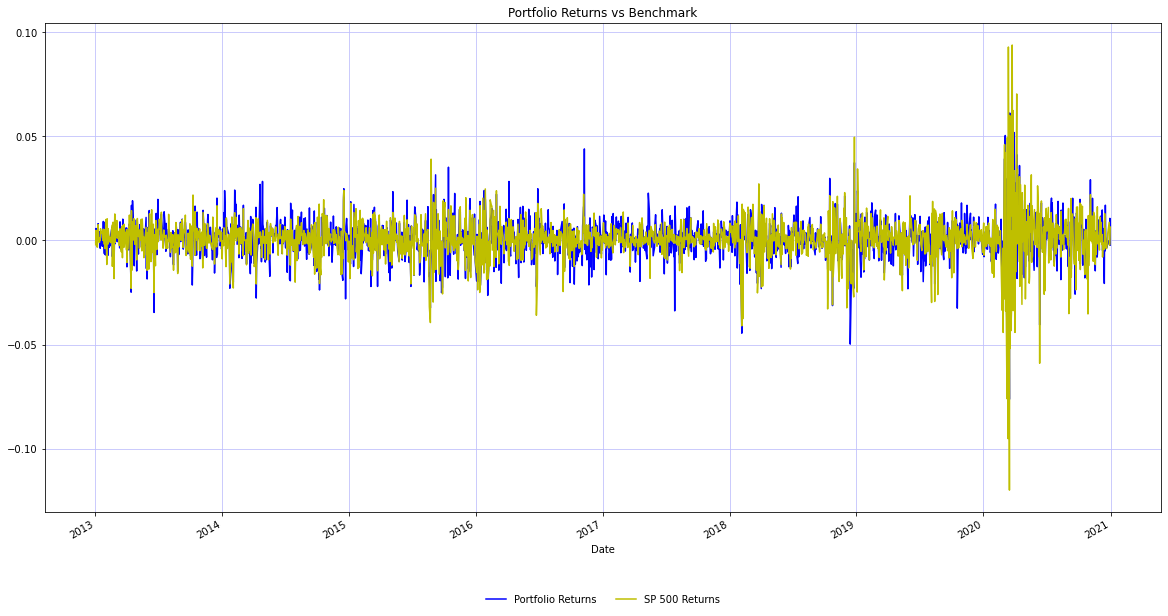

In [55]:
fig, ax = plt.subplots(figsize=(20,10))

port_ret.plot(ax = plt.gca(),grid = True, color = "b", label ="Portfolio Returns")

benchmark_ret.plot(ax = plt.gca(),grid = True, color = "y", label ="SP 500 Returns")

ax.set_title('Portfolio Returns vs Benchmark')

ax.grid(c = (0.75, 0.75, 0.99))

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0)

- Plotting the regression line of the portfolio

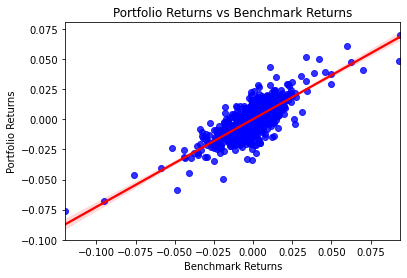

In [56]:
g = sns.regplot(benchmark_ret.values, port_ret.values, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

plt.xlabel("Benchmark Returns")

plt.ylabel("Portfolio Returns")

plt.title("Portfolio Returns vs Benchmark Returns")

plt.show()

In [57]:
(beta, alpha) = stats.linregress(benchmark_ret.values, port_ret.values)[0:2]
print("The portfolio beta is", round(beta, 4))

The portfolio beta is 0.7293


- Treynor Ratio

In [58]:
tr = (round(optimal_stats['return'],6)-rfr)/beta
tr

0.25323552311149267

- Final Portfolio

In [59]:
returns =  round(optimal_stats['return']*100,4)

risk = round(optimal_stats['volatility']*100,4)

sr = round(optimal_stats['sharpe'],4)

tr = (round(optimal_stats['return'],6)-rfr) / beta

beta = (beta, alpha) = stats.linregress(benchmark_ret.values, port_ret.values)[0:2]


print("---------------------------------------")
print('Optimal Portfolio Return: ', returns)
print("---------------------------------------")
print('Optimal Portfolio Volatility: ', risk)
print("---------------------------------------")
print('Optimal Portfolio Sharpe Ratio: ', sr)
print("---------------------------------------")
print("Optimal Portfolio Treynor Ratio", round(tr,4))
print("---------------------------------------")
print("Optimal Portfolio Beta", round(beta,4))
print("---------------------------------------")

---------------------------------------
Optimal Portfolio Return:  19.4697
---------------------------------------
Optimal Portfolio Volatility:  17.7121
---------------------------------------
Optimal Portfolio Sharpe Ratio:  1.0428
---------------------------------------
Optimal Portfolio Treynor Ratio 0.2532
---------------------------------------
Optimal Portfolio Beta 0.7293
---------------------------------------
